# Projeto de Eficiência Energética - UCI Energy Efficiency Dataset

# **Plano para AT2 - Modelagem e Avaliação de Algoritmos**

**por Tiago Dutra Galvão**

# **3. Otimização de Hiperparâmetros**

**Vamos criar um processo para otimizar os hiperparâmetros dos melhores modelos:**

Melhores modelos para Heating Load:


,Modelo,R2_Test,RMSE_Test
5,XGBoost,0.998389,0.404146
4,GradientBoosting,0.997587,0.494623
3,RandomForest,0.997455,0.507999



Melhores modelos para Cooling Load:


,Modelo,R2_Test,RMSE_Test
13,NeuralNetwork,0.988982,0.996548
12,XGBoost,0.987411,1.065252
11,GradientBoosting,0.974510,1.515806


Otimizando XGBoost para Heating_Load...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Otimização concluída. RMSE Test: 0.3769, R² Test: 0.9986
Otimizando GradientBoosting para Heating_Load...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Otimização concluída. RMSE Test: 0.4209, R² Test: 0.9983
Otimizando RandomForest para Heating_Load...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Otimização concluída. RMSE Test: 0.5080, R² Test: 0.9975
Otimizando NeuralNetwork para Cooling_Load...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Applications/anaconda3/envs/analise_preditiva/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/analise_preditiva/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/analise_preditiva/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/analise_preditiva/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

Otimização concluída. RMSE Test: 2.8054, R² Test: 0.9127
Otimizando XGBoost para Cooling_Load...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Otimização concluída. RMSE Test: 0.9921, R² Test: 0.9891
Otimizando GradientBoosting para Cooling_Load...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Otimização concluída. RMSE Test: 1.1502, R² Test: 0.9853

Todos os modelos otimizados e avaliados com sucesso!


,Modelo,Target,RMSE_Test,R2_Test
0,XGBoost_otimizado,Heating_Load,0.376933,0.998599
1,GradientBoosting_otimizado,Heating_Load,0.420856,0.998253
2,RandomForest_otimizado,Heating_Load,0.507999,0.997455
3,NeuralNetwork_otimizado,Cooling_Load,2.805441,0.912684
4,XGBoost_otimizado,Cooling_Load,0.992106,0.989080
5,GradientBoosting_otimizado,Cooling_Load,1.150151,0.985324


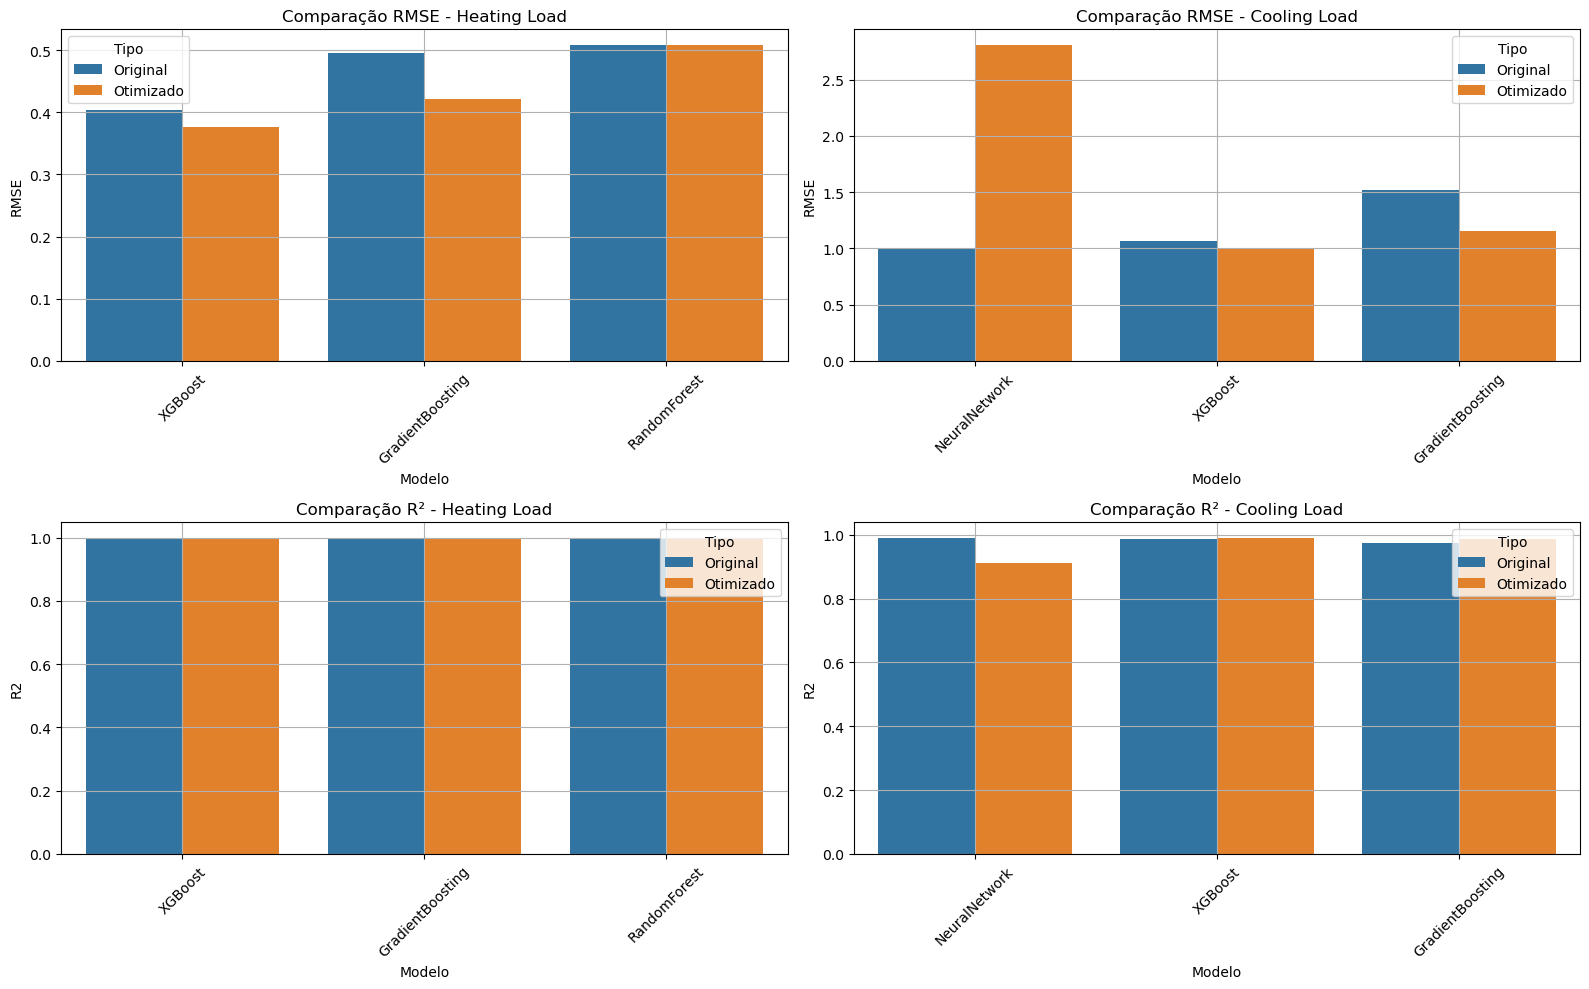


Melhor modelo otimizado para Heating Load: XGBoost_otimizado
R²: 0.9986, RMSE: 0.3769
Parâmetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Melhor modelo otimizado para Cooling Load: XGBoost_otimizado
R²: 0.9891, RMSE: 0.9921
Parâmetros: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}


In [1]:
# Notebook: at2_modelagem/03_otimizacao_hiperparametros.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import time

# Carregar os dados pré-processados
X_train = np.load('../../data/processed/X_train_preprocessed.npy')
X_test = np.load('../../data/processed/X_test_preprocessed.npy')
y_heating_train = np.load('../../data/processed/y_heating_train.npy')
y_heating_test = np.load('../../data/processed/y_heating_test.npy')
y_cooling_train = np.load('../../data/processed/y_cooling_train.npy')
y_cooling_test = np.load('../../data/processed/y_cooling_test.npy')

# Carregar os resultados da avaliação anterior
df_resultados = pd.read_csv('../../reports/resultados_modelos.csv')
df_heating = df_resultados[df_resultados['Target'] == 'Heating_Load']
df_cooling = df_resultados[df_resultados['Target'] == 'Cooling_Load']

# Identificar os três melhores modelos para cada target
melhores_heating = df_heating.nlargest(3, 'R2_Test')
melhores_cooling = df_cooling.nlargest(3, 'R2_Test')

print("Melhores modelos para Heating Load:")
display(melhores_heating[['Modelo', 'R2_Test', 'RMSE_Test']])

print("\nMelhores modelos para Cooling Load:")
display(melhores_cooling[['Modelo', 'R2_Test', 'RMSE_Test']])

# Configurações de hiperparâmetros para otimização
param_grids = {
    'Ridge': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    'Lasso': {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'colsample_bytree': [0.7, 0.8, 0.9]
    },
    'NeuralNetwork': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
}

# Mapeamento de nomes para modelos
modelo_classes = {
    'Ridge': Ridge,
    'Lasso': Lasso,
    'RandomForest': RandomForestRegressor,
    'GradientBoosting': GradientBoostingRegressor,
    'XGBoost': XGBRegressor,
    'NeuralNetwork': MLPRegressor
}

# Função para otimizar hiperparâmetros e avaliar
def otimizar_modelo(nome_modelo, X_train, X_test, y_train, y_test, target_name):
    print(f"Otimizando {nome_modelo} para {target_name}...")
    
    # Criar o modelo base
    modelo_classe = modelo_classes[nome_modelo]
    modelo_base = modelo_classe(random_state=42) if 'random_state' in modelo_classe().get_params() else modelo_classe()
    
    # Obter o grid de parâmetros
    param_grid = param_grids[nome_modelo]
    
    # Realizar Grid Search
    grid_search = GridSearchCV(
        estimator=modelo_base,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    # Treinar o modelo
    inicio = time.time()
    grid_search.fit(X_train, y_train)
    fim = time.time()
    tempo_treino = fim - inicio
    
    # Obter o melhor modelo
    melhor_modelo = grid_search.best_estimator_
    melhores_params = grid_search.best_params_
    
    # Avaliar o melhor modelo
    y_pred_train = melhor_modelo.predict(X_train)
    y_pred_test = melhor_modelo.predict(X_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    # Salvar o melhor modelo
    joblib.dump(melhor_modelo, f'../../models/{nome_modelo}_otimizado_{target_name}.pkl')
    
    # Criar dicionário com os resultados
    resultados = {
        'Modelo': f"{nome_modelo}_otimizado",
        'Target': target_name,
        'RMSE_Train': rmse_train,
        'RMSE_Test': rmse_test,
        'MAE_Train': mae_train,
        'MAE_Test': mae_test,
        'R2_Train': r2_train,
        'R2_Test': r2_test,
        'Melhores_Parametros': melhores_params,
        'Tempo_Treino': tempo_treino
    }
    
    print(f"Otimização concluída. RMSE Test: {rmse_test:.4f}, R² Test: {r2_test:.4f}")
    return resultados

# Otimizar os melhores modelos para Heating Load
resultados_otimizados_heating = []
for _, row in melhores_heating.iterrows():
    nome_modelo = row['Modelo']
    # Verificar se o modelo está no dicionário de parâmetros
    if nome_modelo in param_grids:
        resultado = otimizar_modelo(nome_modelo, X_train, X_test, y_heating_train, y_heating_test, "Heating_Load")
        resultados_otimizados_heating.append(resultado)

# Otimizar os melhores modelos para Cooling Load
resultados_otimizados_cooling = []
for _, row in melhores_cooling.iterrows():
    nome_modelo = row['Modelo']
    # Verificar se o modelo está no dicionário de parâmetros
    if nome_modelo in param_grids:
        resultado = otimizar_modelo(nome_modelo, X_train, X_test, y_cooling_train, y_cooling_test, "Cooling_Load")
        resultados_otimizados_cooling.append(resultado)

# Combinar os resultados
todos_resultados_otimizados = resultados_otimizados_heating + resultados_otimizados_cooling
df_resultados_otimizados = pd.DataFrame([{k: v for k, v in r.items() if k != 'Melhores_Parametros'} 
                                         for r in todos_resultados_otimizados])

# Adicionar os melhores parâmetros como coluna separada
for i, r in enumerate(todos_resultados_otimizados):
    df_resultados_otimizados.at[i, 'Melhores_Parametros'] = str(r['Melhores_Parametros'])

# Salvar os resultados otimizados
df_resultados_otimizados.to_csv('../../reports/resultados_modelos_otimizados.csv', index=False)

print("\nTodos os modelos otimizados e avaliados com sucesso!")
display(df_resultados_otimizados[['Modelo', 'Target', 'RMSE_Test', 'R2_Test']])

# Visualizar a comparação entre os modelos originais e otimizados
# Preparar dados para o gráfico
resultados_comparacao = []

# Adicionar resultados originais
for _, row in melhores_heating.iterrows():
    if row['Modelo'] in param_grids:
        resultados_comparacao.append({
            'Modelo': row['Modelo'],
            'Target': 'Heating_Load',
            'Tipo': 'Original',
            'RMSE': row['RMSE_Test'],
            'R2': row['R2_Test']
        })

for _, row in melhores_cooling.iterrows():
    if row['Modelo'] in param_grids:
        resultados_comparacao.append({
            'Modelo': row['Modelo'],
            'Target': 'Cooling_Load',
            'Tipo': 'Original',
            'RMSE': row['RMSE_Test'],
            'R2': row['R2_Test']
        })

# Adicionar resultados otimizados
for r in resultados_otimizados_heating:
    resultados_comparacao.append({
        'Modelo': r['Modelo'].replace('_otimizado', ''),
        'Target': 'Heating_Load',
        'Tipo': 'Otimizado',
        'RMSE': r['RMSE_Test'],
        'R2': r['R2_Test']
    })

for r in resultados_otimizados_cooling:
    resultados_comparacao.append({
        'Modelo': r['Modelo'].replace('_otimizado', ''),
        'Target': 'Cooling_Load',
        'Tipo': 'Otimizado',
        'RMSE': r['RMSE_Test'],
        'R2': r['R2_Test']
    })

df_comparacao = pd.DataFrame(resultados_comparacao)

# Plotar a comparação de RMSE
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
df_heat_comp = df_comparacao[(df_comparacao['Target'] == 'Heating_Load')]
sns.barplot(x='Modelo', y='RMSE', hue='Tipo', data=df_heat_comp)
plt.title('Comparação RMSE - Heating Load')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(2, 2, 2)
df_cool_comp = df_comparacao[(df_comparacao['Target'] == 'Cooling_Load')]
sns.barplot(x='Modelo', y='RMSE', hue='Tipo', data=df_cool_comp)
plt.title('Comparação RMSE - Cooling Load')
plt.xticks(rotation=45)
plt.grid(True)

# Plotar a comparação de R²
plt.subplot(2, 2, 3)
sns.barplot(x='Modelo', y='R2', hue='Tipo', data=df_heat_comp)
plt.title('Comparação R² - Heating Load')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(2, 2, 4)
sns.barplot(x='Modelo', y='R2', hue='Tipo', data=df_cool_comp)
plt.title('Comparação R² - Cooling Load')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.savefig('../../reports/figures/comparacao_modelos_otimizados.png')
plt.show()

# Identificar o melhor modelo otimizado para cada target
melhor_heating_otimizado = df_resultados_otimizados[df_resultados_otimizados['Target'] == 'Heating_Load'].loc[
    df_resultados_otimizados[df_resultados_otimizados['Target'] == 'Heating_Load']['R2_Test'].idxmax()
]

melhor_cooling_otimizado = df_resultados_otimizados[df_resultados_otimizados['Target'] == 'Cooling_Load'].loc[
    df_resultados_otimizados[df_resultados_otimizados['Target'] == 'Cooling_Load']['R2_Test'].idxmax()
]

print(f"\nMelhor modelo otimizado para Heating Load: {melhor_heating_otimizado['Modelo']}")
print(f"R²: {melhor_heating_otimizado['R2_Test']:.4f}, RMSE: {melhor_heating_otimizado['RMSE_Test']:.4f}")
print(f"Parâmetros: {melhor_heating_otimizado['Melhores_Parametros']}")

print(f"\nMelhor modelo otimizado para Cooling Load: {melhor_cooling_otimizado['Modelo']}")
print(f"R²: {melhor_cooling_otimizado['R2_Test']:.4f}, RMSE: {melhor_cooling_otimizado['RMSE_Test']:.4f}")
print(f"Parâmetros: {melhor_cooling_otimizado['Melhores_Parametros']}")